In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

## Input

In [2]:
activate_plotly = True # turn expensive renderings on and off
threshold = 0.6 # 0.45 to find the upper left recangle

# Define the paths
# target_image_path = '3boxes_labels.png'
# target_image_path = '00_3boxes_labels_scaled.png' # default
# target_image_path = 'door_system.png' # version 1 for paper
# target_image_path = 'door_system_after_preprocessing_big_padding.png' # version 2 for paper with scaled vertex
target_image_path = 'crossing.png'
# target_image_path = 'system.png'
# target_image_path = '3boxes_grey_input.png'
# template_image_path = 'task_scaled3.png'
# template_image_path = 'task_white.png'
# template_image_path = 'task.png'
template_image_path = 'task_180_200.png'
# template_image_path = 'greytemplate.png'

target_img = cv2.imread(target_image_path)
template_img = cv2.imread(template_image_path)

img = target_img

## Template Matching

Use opencv template matching: https://docs.opencv.org/4.10.0/df/dfb/group__imgproc__object.html

In [3]:
# Apply template matching
res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED)

## Thresholding

### Threshold Template Matching

In [4]:
loc = np.where(res >= threshold)
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

Found 54 matches with a threshold of 0.6


### Analysis After Thresholding

In [5]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

## From Pixels to Boxes

### Bounding Boxes before Foreground check
Draw bounding boxes for every single matched template. (A 180x200 box for every single pixel)

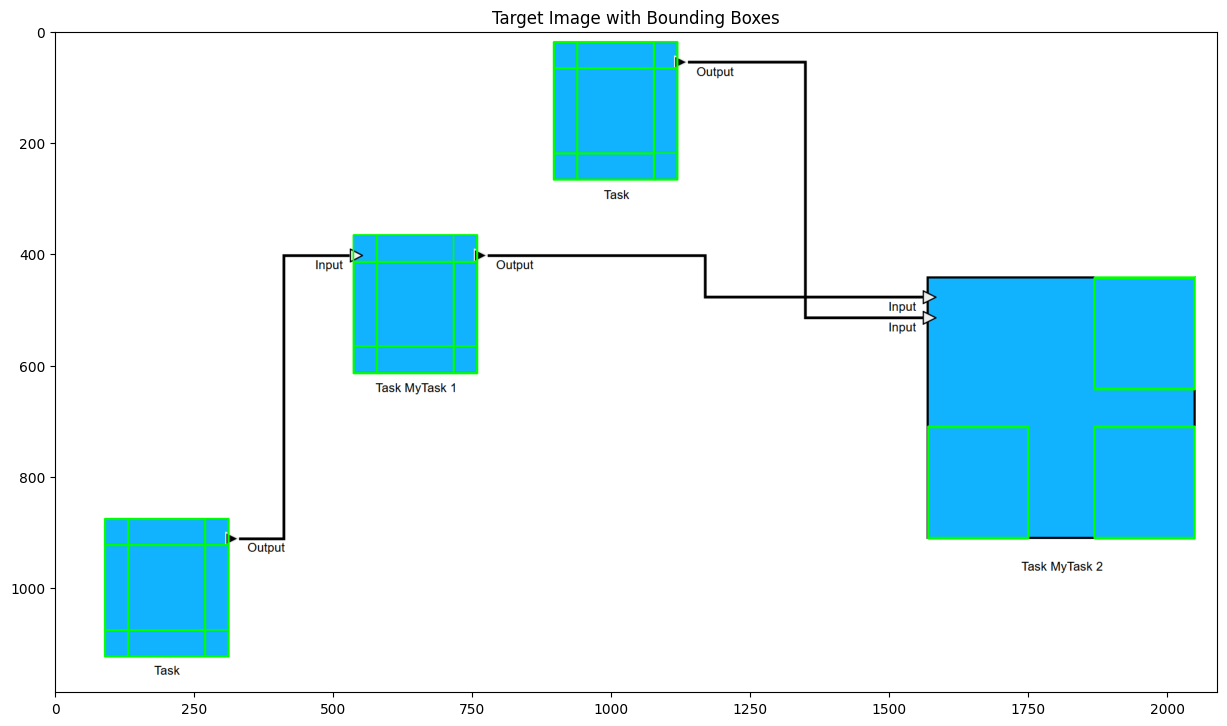

In [6]:
# Draw the bounding boxes
target_img_with_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0])
    cv2.rectangle(target_img_with_boxes, pt, bottom_right, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Bounding Boxes')  
plt.show()

### Threshold to get Foreground
Original target image is thresholded to get foreground. This is used to restrict matches to the foreground. TODO: is this still a thing?

In [7]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

### Filter Foreground
Filters the bounding boxes of the vertices. Only locations in the foreground are kept. This is probably obsolete. 

In [8]:
loc_foreground = []
for pt in zip(*loc[::-1]):
    if np.all(target_thresh[pt[1]:pt[1] + template_img.shape[0], pt[0]:pt[0] + template_img.shape[1]] == 255):
        loc_foreground.append(pt)

### Analyse Foreground Check
Foregound check has currently negligible effect and could be deactivated.

In [9]:
# Compare loc and loc_foreground
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")
print(f"Found {len(loc_foreground)} matches with a threshold of {threshold} and foreground filter")

Found 54 matches with a threshold of 0.6
Found 54 matches with a threshold of 0.6 and foreground filter


### Fill bounding boxes
Fills the bounding boxes of the vertices

In [10]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in zip(*loc[::-1]):
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), 255, -1)

### Find Contours in the super boxes
The overlapping bounding boxes are now puzzled together to big boxes

In [11]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours and save their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (0, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))

bounding_boxes = [(x-3, y-3, w+3, h+3) for (x, y, w, h) in bounding_boxes]

print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(86, 873, 227, 252), (1865, 707, 185, 206), (1566, 707, 185, 206), (1865, 439, 185, 206), (533, 363, 227, 253), (893, 16, 227, 252)]


#### functions

In [12]:
def is_line_inside_bounding_boxes(line, bounding_boxes):
    x1, y1, x2, y2 = line
    for (bx, by, bw, bh) in bounding_boxes:
        if (bx <= x1 <= bx + bw and by <= y1 <= by + bh) or (bx <= x2 <= bx + bw and by <= y2 <= by + bh):
            return True
    return False

def snap_to_90_degrees(line):
    x1, y1, x2, y2 = line
    if abs(x2 - x1) > abs(y2 - y1):
        # Snap to horizontal
        y2 = y1
    else:
        # Snap to vertical
        x2 = x1
    return (x1, y1, x2, y2)

def merge_lines(lines, min_distance=20, min_angle=10):
    merged_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        merged = False
        for merged_line in merged_lines:
            mx1, my1, mx2, my2 = merged_line
            if np.linalg.norm((x1 - mx1, y1 - my1)) < min_distance or np.linalg.norm((x2 - mx2, y2 - my2)) < min_distance:
                angle1 = np.arctan2(y2 - y1, x2 - x1)
                angle2 = np.arctan2(my2 - my1, mx2 - mx1)
                if abs(angle1 - angle2) < np.deg2rad(min_angle):
                    merged_line[0] = min(x1, mx1)
                    merged_line[1] = min(y1, my1)
                    merged_line[2] = max(x2, mx2)
                    merged_line[3] = max(y2, my2)
                    merged = True
                    break
        if not merged:
            merged_lines.append([x1, y1, x2, y2])
    return merged_lines

#### detecting lines
use bounding boxes to exclude lines from line detection algorythm

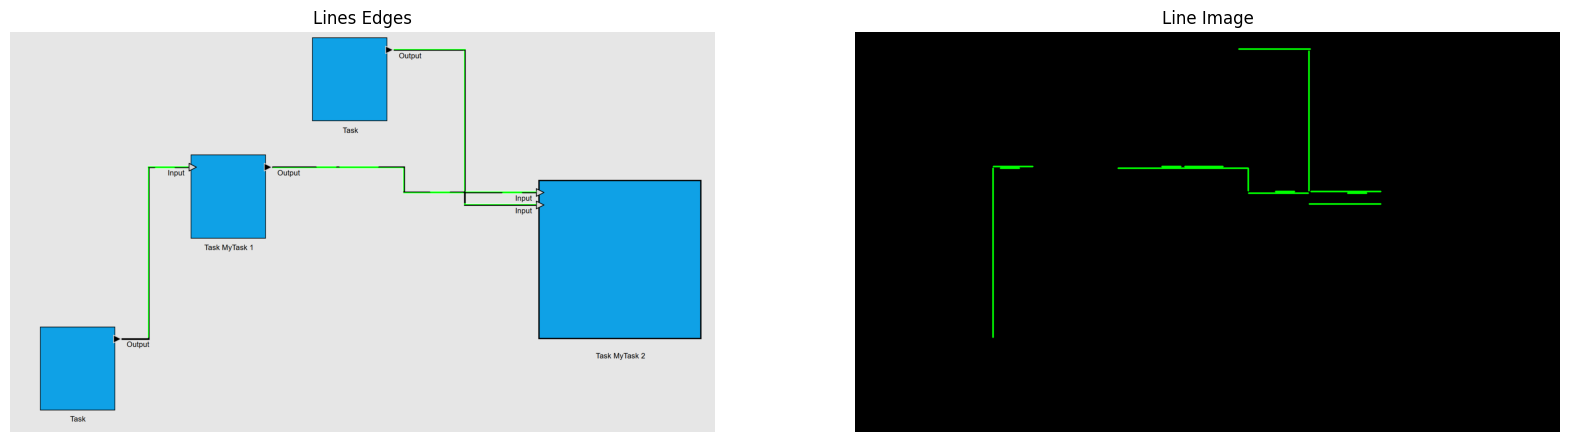

Filtered Lines:
Line 1: (1352, 475) to (1559, 475)
Line 2: (780, 406) to (1166, 406)
Line 3: (1346, 473) to (1346, 59)
Line 4: (409, 907) to (409, 406)
Line 5: (410, 401) to (527, 401)
Line 6: (1138, 53) to (1350, 53)
Line 7: (1167, 480) to (1344, 480)
Line 8: (1347, 512) to (1559, 512)
Line 9: (910, 401) to (966, 401)
Line 10: (431, 406) to (487, 406)
Line 11: (1166, 473) to (1166, 407)
Line 12: (1035, 401) to (1091, 401)
Line 13: (1247, 475) to (1303, 475)
Line 14: (1461, 480) to (1517, 480)
Line 15: (978, 401) to (1034, 401)


In [13]:
# Read image and convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

# Edge detection using Canny
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Hough Transform parameters
rho = 1  # Distance resolution in pixels
theta = np.pi / 180  # Angle resolution in radians
threshold = 15  # Accumulator threshold
min_line_length = 50  # Minimum line length
max_line_gap = 1  # Maximum gap between lines
line_image = np.copy(img) * 0  # Black image for lines

# Run Hough on edge detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Filter lines
filtered_lines = []
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            if not is_line_inside_bounding_boxes((x1, y1, x2, y2), bounding_boxes):
                # Filter out very short lines
                if np.linalg.norm((x2 - x1, y2 - y1)) > min_line_length:
                    filtered_lines.append((x1, y1, x2, y2))

# Merge lines
merged_lines = merge_lines(filtered_lines)

# Snap merged lines to 90 degrees
snapped_lines = [snap_to_90_degrees(line) for line in merged_lines]

# Draw snapped lines
for x1, y1, x2, y2 in snapped_lines:
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Draw the result
lines_edges = cv2.addWeighted(img, 0.9, line_image, 1, 0)

# Convert BGR to RGB for displaying with matplotlib
lines_edges_rgb = cv2.cvtColor(lines_edges, cv2.COLOR_BGR2RGB)

# Display the image in Jupyter Notebook
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(lines_edges_rgb)
plt.title('Lines Edges')
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Image')
plt.axis('off')  # Hide the axis

plt.show()

print("Filtered Lines:")
for i, (x1, y1, x2, y2) in enumerate(snapped_lines, start=1):
    print(f"Line {i}: ({x1}, {y1}) to ({x2}, {y2})")

# post processing

### sorting lines into horizontal and vertical lists

Horizontal Lines:
Line 1: (1352, 475) to (1559, 475)
Line 2: (780, 406) to (1166, 406)
Line 3: (410, 401) to (527, 401)
Line 4: (1138, 53) to (1350, 53)
Line 5: (1167, 480) to (1344, 480)
Line 6: (1347, 512) to (1559, 512)
Line 7: (910, 401) to (966, 401)
Line 8: (431, 406) to (487, 406)
Line 9: (1035, 401) to (1091, 401)
Line 10: (1247, 475) to (1303, 475)
Line 11: (1461, 480) to (1517, 480)
Line 12: (978, 401) to (1034, 401)

Vertical Lines:
Line 1: (1346, 473) to (1346, 59)
Line 2: (409, 907) to (409, 406)
Line 3: (1166, 473) to (1166, 407)


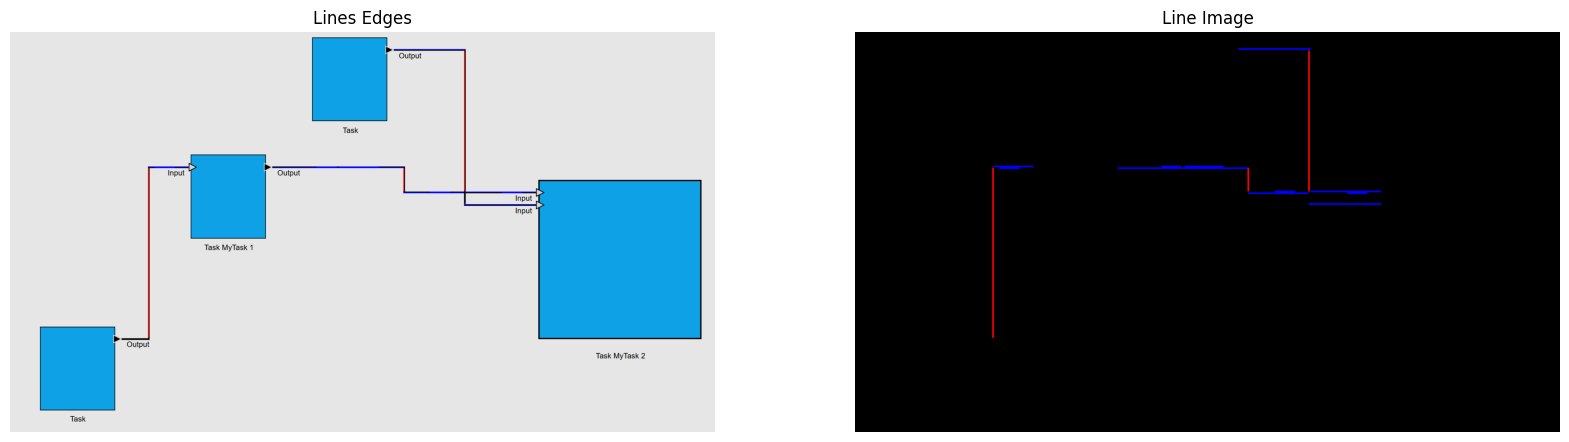

In [14]:
# Sort lines into horizontal and vertical
line_segments_hor_sorted = []
line_segments_ver_sorted = []

for x1, y1, x2, y2 in snapped_lines:
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    if -10 <= angle <= 10 or 170 <= angle <= 190:
        line_segments_hor_sorted.append(((x1, y1), (x2, y2)))
    elif 80 <= angle <= 100 or -100 <= angle <= -80:
        line_segments_ver_sorted.append(((x1, y1), (x2, y2)))

# Print sorted lines
print("Horizontal Lines:")
for i, ((x1, y1), (x2, y2)) in enumerate(line_segments_hor_sorted, start=1):
    print(f"Line {i}: ({x1}, {y1}) to ({x2}, {y2})")

print("\nVertical Lines:")
for i, ((x1, y1), (x2, y2)) in enumerate(line_segments_ver_sorted, start=1):
    print(f"Line {i}: ({x1}, {y1}) to ({x2}, {y2})")

# Draw horizontal and vertical lines in different colors
line_image = np.copy(img) * 0  # Black image for lines

for (x1, y1), (x2, y2) in line_segments_hor_sorted:
    cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Blue for horizontal lines

for (x1, y1), (x2, y2) in line_segments_ver_sorted:
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Red for vertical lines

# Draw the result
lines_edges = cv2.addWeighted(img, 0.9, line_image, 1, 0)

# Convert BGR to RGB for displaying with matplotlib
lines_edges_rgb = cv2.cvtColor(lines_edges, cv2.COLOR_BGR2RGB)

# Display the image in Jupyter Notebook
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(lines_edges_rgb)
plt.title('Lines Edges')
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Image')
plt.axis('off')  # Hide the axis

plt.show()

## Chain the line segments together
It starts with the leftest horizontal line segment and walks its way to the end of the edge what the polygonal chain. Currently this does not support starting with a vertical line segment. This needs to be generalized in future. For example it might use some heuristics to check that it is not an intermediate line segment, but a starting or ending line segment of a chain.

Take the leftest horizontal segment. Search for closest starting/ending points of vertical segment. Store, which segments are used. Continue alternativ vertical/horizontal. Finish polygonal chain if no starting/ending point within a distance of 7.

Well explained in PowerPoint slides.

In [15]:
def calculate_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5


def find_closest_segment(base_segment, candidate_segments, max_distance=7):
    """Find the closest segment from candidate_segments to either the start or end point of the base_segment. But only to a maximum distance of max_distance."""
    closest_segment = None
    closest_distance = max_distance + 1  # Initialize with a value slightly larger than max_distance

    # Check both the start and end points of the base segment
    for base_point in [base_segment[0], base_segment[1]]:
        for seg in candidate_segments:
            # Check both start and end points of the candidate segment
            for point in [seg[0], seg[1]]:
                distance = calculate_distance(base_point, point)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_segment = seg

    return closest_segment if closest_distance <= max_distance else None


def group_segments_into_chains(h_segments, v_segments, max_distance=10):
    chains = []
    used_segments = set()

    # Function to add segments to 'used_segments' and remove them from 'h_segments' or 'v_segments'
    def mark_used(seg):
        if seg in h_segments:
            h_segments.remove(seg)
        elif seg in v_segments:
            v_segments.remove(seg)
        used_segments.add(seg)

    # Start with horizontal segments as potential starting points
    for h_seg in list(h_segments):  # Use list(...) to avoid modifying the list while iterating
        print(f"Processing horizontal segment: {h_seg}")
        if h_seg in used_segments:
            print("Already used. Skipping.")
            continue
        current_chain = [h_seg] # chain starts with a horizontal segment
        print(f"Starting chain with: {h_seg}")
        mark_used(h_seg)

        # Alternate between finding vertical and horizontal segments to connect
        searching_for = 'vertical'
        while True:
            if searching_for == 'vertical':
                next_seg = find_closest_segment(current_chain[-1], v_segments, max_distance)
                print(f"Next vertical segment: {next_seg}")
                if next_seg:
                    current_chain.append(next_seg)
                    mark_used(next_seg)
                    searching_for = 'horizontal'  # Switch to searching for the next horizontal segment
                else:
                    print("No further vertical segment found. This chain is complete.")
                    break  # No more segments to connect
            else:
                next_seg = find_closest_segment(current_chain[-1], h_segments, max_distance)
                print(f"Next horizontal segment: {next_seg}")
                if next_seg:
                    current_chain.append(next_seg)
                    mark_used(next_seg)
                    searching_for = 'vertical'
                else:
                    print("No further horizontal segment found. This chain is complete.\n")
                    break

        chains.append(current_chain)

    return chains

line_segment_chains = group_segments_into_chains(line_segments_hor_sorted.copy(), line_segments_ver_sorted.copy())

Processing horizontal segment: ((np.int32(1352), np.int32(475)), (np.int32(1559), np.int32(475)))
Starting chain with: ((np.int32(1352), np.int32(475)), (np.int32(1559), np.int32(475)))
Next vertical segment: ((np.int32(1346), np.int32(473)), (np.int32(1346), np.int32(59)))
Next horizontal segment: ((np.int32(1138), np.int32(53)), (np.int32(1350), np.int32(53)))
Next vertical segment: None
No further vertical segment found. This chain is complete.
Processing horizontal segment: ((np.int32(780), np.int32(406)), (np.int32(1166), np.int32(406)))
Starting chain with: ((np.int32(780), np.int32(406)), (np.int32(1166), np.int32(406)))
Next vertical segment: ((np.int32(1166), np.int32(473)), (np.int32(1166), np.int32(407)))
Next horizontal segment: ((np.int32(1167), np.int32(480)), (np.int32(1344), np.int32(480)))
Next vertical segment: None
No further vertical segment found. This chain is complete.
Processing horizontal segment: ((np.int32(410), np.int32(401)), (np.int32(527), np.int32(401)))

#### Print the Chains
Can be compared to plotted coordinates in image above.

In [16]:
# Print the chains
for i, chain in enumerate(line_segment_chains):
    print(f"Chain {i}: {chain}")

Chain 0: [((np.int32(1352), np.int32(475)), (np.int32(1559), np.int32(475))), ((np.int32(1346), np.int32(473)), (np.int32(1346), np.int32(59))), ((np.int32(1138), np.int32(53)), (np.int32(1350), np.int32(53)))]
Chain 1: [((np.int32(780), np.int32(406)), (np.int32(1166), np.int32(406))), ((np.int32(1166), np.int32(473)), (np.int32(1166), np.int32(407))), ((np.int32(1167), np.int32(480)), (np.int32(1344), np.int32(480)))]
Chain 2: [((np.int32(410), np.int32(401)), (np.int32(527), np.int32(401))), ((np.int32(409), np.int32(907)), (np.int32(409), np.int32(406)))]
Chain 3: [((np.int32(1347), np.int32(512)), (np.int32(1559), np.int32(512)))]
Chain 4: [((np.int32(910), np.int32(401)), (np.int32(966), np.int32(401)))]
Chain 5: [((np.int32(431), np.int32(406)), (np.int32(487), np.int32(406)))]
Chain 6: [((np.int32(1035), np.int32(401)), (np.int32(1091), np.int32(401)))]
Chain 7: [((np.int32(1247), np.int32(475)), (np.int32(1303), np.int32(475)))]
Chain 8: [((np.int32(1461), np.int32(480)), (np.

#### Visualize the Chains
still sets of line segments with a gap

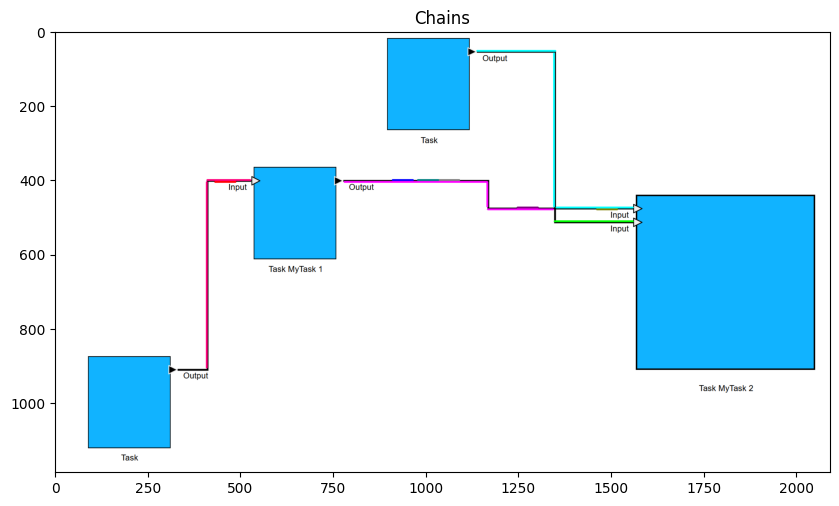

In [17]:
# Draw the chains, using different colors for each chain
chain_img = target_img.copy()
colors = [(255, 255, 0), (255, 0, 255), (125, 0, 255),  (0, 255, 0), (255, 0, 0), (0, 0, 255), (128, 128, 128), (128, 0, 128), (0, 128, 128), (128, 128, 0), (0, 128, 0), (255, 105, 180), (139, 69, 19)]

for i, chain in enumerate(line_segment_chains):
    color = colors[i % len(colors)]
    for start, end in chain:
        cv2.line(chain_img, start, end, color, 4)

# Plot the chains
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(chain_img, cv2.COLOR_BGR2RGB))
plt.title('Chains')
plt.show()

#### From Chains to Polylines

In [18]:
# currently not used
# def calculate_intersection(horizontal_seg, vertical_seg):
#     """Calculate the intersection point of a horizontal and a vertical segment."""
#     # The intersection point's x-coordinate comes from the vertical segment,
#     # and the y-coordinate comes from the horizontal segment.
#     print(f"Calculating intersection between {horizontal_seg} and {vertical_seg}")
#     return (vertical_seg[0][0], horizontal_seg[0][1])

def calculate_intersection(seg1, seg2):
    """
    Calculate the intersection point of two line segments.
    Very generic, does not assume that the segments are orthogonal.

    Parameters:
    - seg1, seg2: The line segments, each represented as a tuple of points ((x1, y1), (x2, y2)).

    Returns:
    - The intersection point (x, y) as a tuple, or None if the segments do not intersect.
    """
    print(f"Calculating intersection between {seg1} and {seg2}")
    # Unpack points
    x1, y1, x2, y2 = seg1[0][0], seg1[0][1], seg1[1][0], seg1[1][1]
    x3, y3, x4, y4 = seg2[0][0], seg2[0][1], seg2[1][0], seg2[1][1]

    # Calculate denominators
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    print(f"Denominator: {den}= ({x1} - {x2}) * ({y3} - {y4}) - ({y1} - {y2}) * ({x3} - {x4})")

    # Check if lines are parallel (denominator = 0)
    if den == 0:
        return None  # Lines are parallel and do not intersect

    # Calculate numerators
    t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
    print(f"t_num: {t_num}= ({x1} - {x3}) * ({y3} - {y4}) - ({y1} - {y3}) * ({x3} - {x4})")
    # u_num = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3))
    # print(f"u_num: {u_num}= -(({x1} - {x2}) * ({y1} - {y3}) - ({y1} - {y2}) * ({x1} - {x3}))")

    # Calculate the intersection point
    t = t_num / den
    print(f"t: {t} = {t_num} / {den}")
    # u = u_num / den

    intersect_x = x1 + t * (x2 - x1)
    print(f"intersect_x: {intersect_x} = {x1} + {t} * ({x2} - {x1})")
    intersect_y = y1 + t * (y2 - y1)
    print(f"intersect_y: {intersect_y} = {y1} + {t} * ({y2} - {y1})")
    return (intersect_x, intersect_y)

def construct_polylines(chains):
    """
    Constructs polylines from chains of line segments, using intersection points between
    consecutive orthogonal segments to form a continuous path.

    Parameters:
    - chains: A list of chains, where each chain is a list of segments ordered such that
      each segment is orthogonal to the next.

    Returns:
    - A list of polylines, where each polyline is represented as an ordered list of points.
    """
    polylines = []

    for chain in chains:
        if not chain:
            continue  # Skip empty chains

        # Start the polyline with the start point of the first segment
        polyline = [chain[0][0]]

        for i in range(len(chain) - 1):
            # Calculate the intersection point between the current segment and the next
            intersection = calculate_intersection(chain[i], chain[i + 1])
            polyline.append(intersection)

        # Add the end point of the last segment in the chain
        polyline.append(chain[-1][1])

        polylines.append(polyline)

    return polylines

polylines = construct_polylines(line_segment_chains)

Calculating intersection between ((np.int32(1352), np.int32(475)), (np.int32(1559), np.int32(475))) and ((np.int32(1346), np.int32(473)), (np.int32(1346), np.int32(59)))
Denominator: -85698= (1352 - 1559) * (473 - 59) - (475 - 475) * (1346 - 1346)
t_num: 2484= (1352 - 1346) * (473 - 59) - (475 - 473) * (1346 - 1346)
t: -0.028985507246376812 = 2484 / -85698
intersect_x: 1346.0 = 1352 + -0.028985507246376812 * (1559 - 1352)
intersect_y: 475.0 = 475 + -0.028985507246376812 * (475 - 475)
Calculating intersection between ((np.int32(1346), np.int32(473)), (np.int32(1346), np.int32(59))) and ((np.int32(1138), np.int32(53)), (np.int32(1350), np.int32(53)))
Denominator: 87768= (1346 - 1346) * (53 - 53) - (473 - 59) * (1138 - 1350)
t_num: 89040= (1346 - 1138) * (53 - 53) - (473 - 53) * (1138 - 1350)
t: 1.0144927536231885 = 89040 / 87768
intersect_x: 1346.0 = 1346 + 1.0144927536231885 * (1346 - 1346)
intersect_y: 53.0 = 473 + 1.0144927536231885 * (59 - 473)
Calculating intersection between ((np.i

#### Print the polylines

In [19]:
# Printing the constructed polylines
for i, polyline in enumerate(polylines):
    print(f"Polyline {i}: {polyline}")

Polyline 0: [(np.int32(1352), np.int32(475)), (np.float64(1346.0), np.float64(475.0)), (np.float64(1346.0), np.float64(53.0)), (np.int32(1350), np.int32(53))]
Polyline 1: [(np.int32(780), np.int32(406)), (np.float64(1166.0), np.float64(406.0)), (np.float64(1166.0), np.float64(480.0)), (np.int32(1344), np.int32(480))]
Polyline 2: [(np.int32(410), np.int32(401)), (np.float64(409.0), np.float64(401.0)), (np.int32(409), np.int32(406))]
Polyline 3: [(np.int32(1347), np.int32(512)), (np.int32(1559), np.int32(512))]
Polyline 4: [(np.int32(910), np.int32(401)), (np.int32(966), np.int32(401))]
Polyline 5: [(np.int32(431), np.int32(406)), (np.int32(487), np.int32(406))]
Polyline 6: [(np.int32(1035), np.int32(401)), (np.int32(1091), np.int32(401))]
Polyline 7: [(np.int32(1247), np.int32(475)), (np.int32(1303), np.int32(475))]
Polyline 8: [(np.int32(1461), np.int32(480)), (np.int32(1517), np.int32(480))]
Polyline 9: [(np.int32(978), np.int32(401)), (np.int32(1034), np.int32(401))]


#### Visualize Polylines

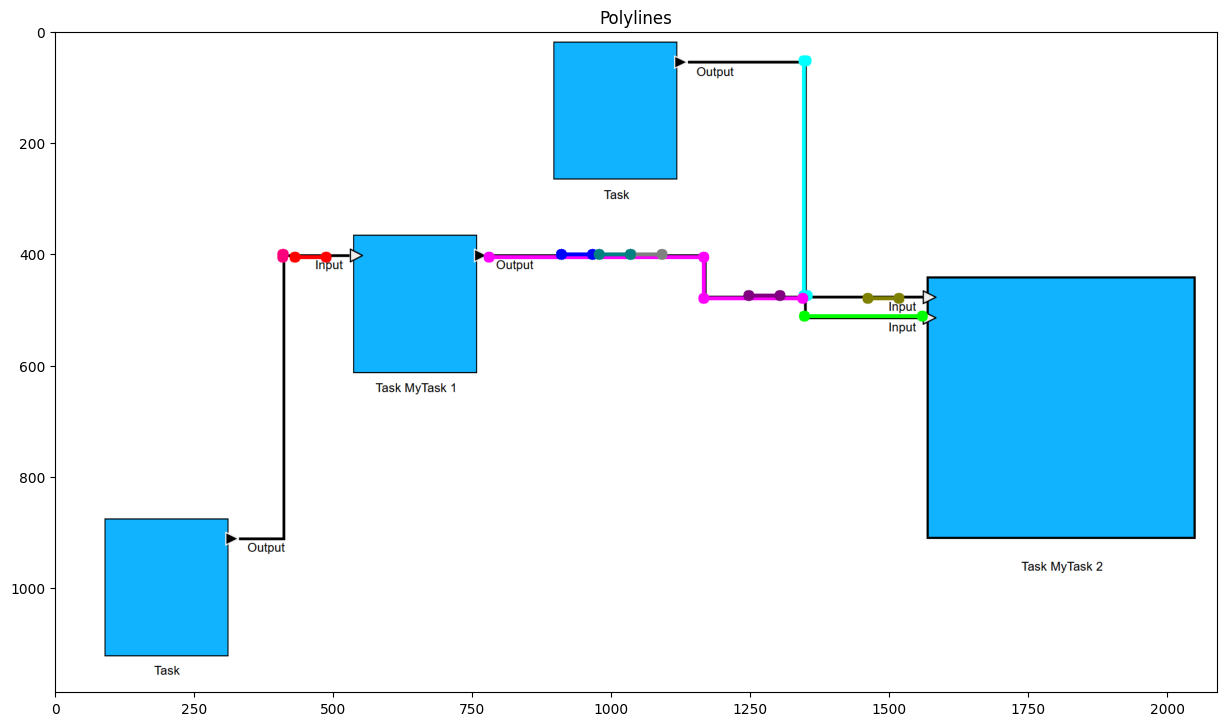

In [20]:
# Convert the polylines to the format expected by OpenCV
opencv_polylines = [np.array(polyline, dtype=np.int32).reshape((-1, 1, 2)) for polyline in polylines]

# Draw the polylines
polyline_img = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)] # take colors from above
    cv2.polylines(polyline_img, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(polyline_img, tuple(point.squeeze()), 10, color, -1)

# Plot the polylines
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(polyline_img, cv2.COLOR_BGR2RGB))
plt.title('Polylines')
plt.show()